# Quantum State Tomography (Unsupervised Learning)

Quantum state tomography (QST) is a machine learning task which aims to reconstruct the full quantum state from measurement results.

__Aim__: Given a variational ansatz $\Psi(\lbrace \boldsymbol{\beta} \rbrace)$ and a set of measurement results, we want to find the parameters $\boldsymbol{\beta}$ which best reproduce the probability distribution of the measurements.

__Training Data__: A set of single shot measurements in some basis, e.g. $\lbrace(100010, \textrm{XZZZYZ}), (011001, \textrm{ZXXYZZ}), \dots \rbrace$

In [1]:
import netket as nk
import numpy as np
import matplotlib.pyplot as plt
import math 
import sys

While in practice, the measurement results can be experimental data e.g. from a quantum computer/simulator, for our purpose, we shall construct our data set by making single shot measurement on a wavefunction that we have obtained via exact diagonalisation. For this tutorial, we shall focus on the one-dimensional anti-ferromagnetic transverse-field Ising model defined by

$$H = \sum_{i} Z_{i}Z_{i+1} + h \sum_{i} X_{i}$$

In [2]:
# Define the Hamiltonian
N = 8
g = nk.graph.Hypercube(length=N, n_dim=1, pbc=False)
hi = nk.hilbert.Spin(g, s=0.5)
ha = nk.operator.Ising(hi, h=1.0)

Next, perform exact diagonalisation to obtain the ground state wavefunction.

In [3]:
# Obtain the ED wavefunction
res = nk.exact.lanczos_ed(ha, first_n=1, compute_eigenvectors=True)
psi = res.eigenvectors[0]
print("Ground state energy =", res.eigenvalues[0])

Ground state energy = -9.837951447459439


Finally, to construct the dataset, we will make single shot measurements in various bases. To obtain a single shot measurement, we need to sample from the wavefunction in the relevant basis.

Since the wavefunction we obtained is in the computational basis (i.e. $Z$ basis), to obtain a single shot measurement in another basis, one would need to transform the wavefunction as follows (this is similar to how one would do a measurement in a different basis on a quantum computer):

X Basis:
$$ |{\Psi}\rangle \rightarrow I_n \otimes \frac{1}{\sqrt{2}}\pmatrix{1 & 1 \\ 1& -1} \otimes I_m \ |\Psi\rangle$$

Y Basis:
$$ |{\Psi}\rangle \rightarrow I_n \otimes \frac{1}{\sqrt{2}}\pmatrix{1 & -i \\ 1& i} \otimes I_m \ |\Psi\rangle$$ 

In [4]:
def build_rotation(hi, basis):
    localop = nk.operator.LocalOperator(hi, 1.0)
    U_X = 1.0 / (math.sqrt(2)) * np.asarray([[1.0, 1.0], [1.0, -1.0]])
    U_Y = 1.0 / (math.sqrt(2)) * np.asarray([[1.0, -1j], [1.0, 1j]])

    N = hi.size

    assert len(basis) == hi.size

    for j in range(hi.size):
        if basis[j] == "X":
            localop *= nk.operator.LocalOperator(hi, U_X, [j])
        if basis[j] == "Y":
            localop *= nk.operator.LocalOperator(hi, U_Y, [j])  
    return localop

In [5]:
n_basis = 2*N
n_shots = 1000


rotations = []
training_samples = []
training_bases = []

np.random.seed(1234)

for m in range(n_basis):
    basis = np.random.choice(
        list("XYZ"), size=N, p=[1.0 / N, 1.0 / N, (N - 2.0) / N]
    )
    
    psi_rotated = np.copy(psi)
    if 'X' in basis or 'Y' in basis:
        rotation = build_rotation(hi, basis)
        psi_rotated = rotation.to_sparse().dot(psi_rotated)
    psi_square = np.square(np.absolute(psi_rotated))
    
    rand_n = np.random.choice(hi.n_states, p=psi_square, size=n_shots)

    for rn in rand_n:
        training_samples.append(hi.number_to_state(rn))
    training_bases += [m] * n_shots

    rotations.append(rotation)

print('Number of bases:', n_basis)
print('Number of shots:', n_shots)
print('Total size of the dataset:', n_basis*n_shots)
print('Some single shot results: (sample, basis)\n', list(zip(training_samples[:3], training_bases[:3])))

Number of bases: 16
Number of shots: 1000
Total size of the dataset: 16000
Some single shot results: (sample, basis)
 [(array([ 1.,  1.,  1., -1.,  1., -1.,  1., -1.]), 0), (array([ 1.,  1., -1.,  1., -1.,  1., -1.,  1.]), 0), (array([-1.,  1., -1.,  1., -1.,  1., -1.,  1.]), 0)]


The basis rotations are contained in ``rotations`` and the single shot measurements are stored in ``training_samples``.  ``training_bases`` is a list of integers which labels each samples in ``training_samples`` according to their basis.

Having obtained the dataset, we can proceed to define the variational ansatz one wishes to train. We shall simply use the Restricted Boltzmann Machine (RBM) with real parameters defined as:

$$ \tilde\psi (\boldsymbol{\sigma})  =  p_{\boldsymbol{\lambda}}(\boldsymbol{\sigma}) e^{i \phi_{\boldsymbol{\mu}}(\boldsymbol{\sigma})} $$

where $\phi_{\boldsymbol{\mu}}(\boldsymbol{\sigma}) = \log  p_{\boldsymbol{\mu}}(\boldsymbol{\sigma})$ and $p_{\boldsymbol{\lambda/\mu}}$ are standard RBM real probability distributions. Notice that the amplitude part $p_{\boldsymbol{\lambda}}$ completely defines the measurements in the Z basis and vice versa.



In [6]:
# Define the variational wavefunction ansatz
ma = nk.machine.RbmSpinPhase(hilbert=hi, alpha=1)

With the variational ansatz as well as the dataset, the quantum state tomography can now be performed. Recall that the aim is to reconstruct a wavefunction $|\Psi_{U}\rangle$ (for our case, the ground state of the 1D TFIM) given single shot measurements of the wavefunction in various bases. The single shot measurements are governed by a probability distribution 

$$P_{b}(\boldsymbol{\sigma}) = | \langle \boldsymbol{\sigma}| \hat{U}_{b} |\Psi_{U}\rangle|^{2}$$ 

which depends on $|\Psi_{U}\rangle$ and the basis $b$ in which the measurement is performed. $\hat{U}_{b}$ is simply the unitary which rotates the wavefunction into the corresponding basis.

Similarly, the variational wavefunction $|\tilde\psi\rangle$ also defines a set of basis dependent probability distributions $\tilde P_{b}(\boldsymbol{\sigma})$. The optimisation procedure is then basically a minimisation task to find the set of parameters $\boldsymbol{\kappa}$ which minimises the total Kullback–Leibler divergence between $\tilde P_{b}$ and $P_{b}$, i.e.

$$ \Xi(\boldsymbol{\kappa}) = \sum_{b} \mathbb{KL}_{b}({\kappa}) $$

where 

$$\mathbb{KL}_{b}({\boldsymbol{\kappa}}) = \sum_{\boldsymbol{\sigma}} P_{b}(\boldsymbol{\sigma}) \log \frac{ P_{b}(\boldsymbol{\sigma})}{\tilde P_{b}(\boldsymbol{\sigma})}$$.

This minimisation can be achieved by gradient descent. Although one does not have access to the underlying probability distributions $P_{b}(\boldsymbol{\sigma})$, the total KL divergence can be estimated by summing over the dataset $\lbrace D_{b} \rbrace$

$$ \Xi(\boldsymbol{\kappa}) = -\sum_{b} \sum_{\boldsymbol{\sigma} \in D_{b}} \log \tilde P_{b}(\boldsymbol{\sigma}) + S $$

where $S$ is the constant entropy of $P_{b}(\boldsymbol{\sigma})$ which can be ignored. The details regarding the computation of the gradients can be found in arXiv:1703.05334.

In addition to reconstructing the quantum state, we would also like to investigate how the size of the dataset affects the quality of the reconstruction. To that end, we shall run the optimisation with different dataset sizes.

In [7]:
# Shuffle our datasets
import random
temp = list(zip(training_bases, training_samples))
random.shuffle(temp)
training_bases, training_samples = zip(*temp)

In [8]:
# Sampler
sa = nk.sampler.MetropolisLocal(machine=ma)

# Optimizer
op = nk.optimizer.AdaDelta()

In [9]:
dataset_sizes = [2000, 4000, 8000, 16000]
# During the optimisation, we would like to keep track 
# of the fidelities and energies
fidelities = {} 
energies = {}

for size in dataset_sizes:
    # First remember to reinitialise the machine
    ma.init_random_parameters(seed=1234, sigma=0.01)
    # Quantum State Tomography object
    qst = nk.unsupervised.Qsr(
        sampler=sa,
        optimizer=op,
        batch_size=300,
        n_samples=300,
        rotations=tuple(rotations[:size]),
        samples=training_samples[:size],
        bases=training_bases,
        method="Gd"
    )
    qst.add_observable(ha, "Energy")
    
    # Run the optimisation using the iterator
    print("Starting optimisation for dataset size", size)
    fidelities_temp = []
    energies_temp = []
    for step in qst.iter(2000, 100):
        # Compute fidelity with exact state
        psima = ma.to_array()
        fidelity = np.abs(np.vdot(psima, psi))
        fidelities_temp.append(fidelity)
    fidelities[size] = fidelities_temp
    energies[size] = energies_temp

Starting optimisation for dataset size 2000
Starting optimisation for dataset size 4000
Starting optimisation for dataset size 8000
Starting optimisation for dataset size 16000


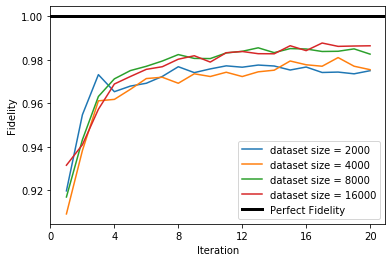

In [10]:
for size in fidelities:
    plt.plot(np.arange(1,21,1),fidelities[size], label='dataset size = '+str(size))
plt.axhline(y=1, xmin=0,
            xmax=20, linewidth=3, color='k', label='Perfect Fidelity')
plt.ylabel('Fidelity')
plt.xlabel('Iteration')
plt.xticks(range(0,21,4))
plt.legend()
plt.show()

As expected, it is relatively clear that with increasing dataset size, the final fidelity does increase.